In [1]:
#Authors: Jonathon Olson (7390381), Anis Tajioui (3577044), Sarah Wonke (8926805)

import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

fatal: destination path 'pytorch-unet' already exists and is not an empty directory.


c:\Users\Jonathon\Desktop\Vertiefung KI & ML\Abgaben\Abgabe 8\U-Net-Segmentierung\pytorch-unet


In [2]:
#Missing dependencies installation

#%pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118
#%pip uninstall -y torch torchvision torchaudio
#%pip uninstall -y torch
#%pip install "numpy<2" --force-reinstall
#%pip install matplotlib
#%pip install torchsummary

In [3]:
# check torch
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not available. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 2070 SUPER


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(128, 128, count=64)

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

input_images shape and range (64, 128, 128, 3) 0 255
target_masks shape and range (64, 6, 128, 128) 0.0 1.0


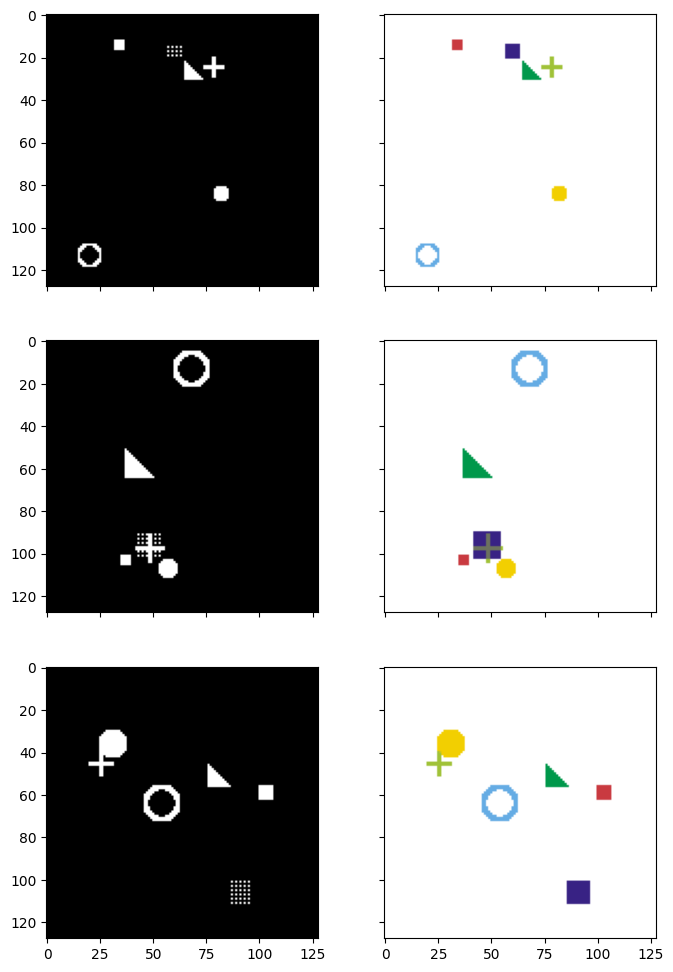

In [5]:
helper.plot_side_by_side([input_images_rgb[:3], target_masks_rgb[:3]])

In [6]:
# prepare data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

class SimDataset(Dataset):
  def __init__(self, count, transform=None):
    self.input_images, self.target_masks = simulation.generate_random_data(128, 128, count=count)
    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.4, 0.5, 0.6], [0.20, 0.21, 0.22]) # skew channels of binary images
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

torch.Size([25, 3, 128, 128]) torch.Size([25, 6, 128, 128])


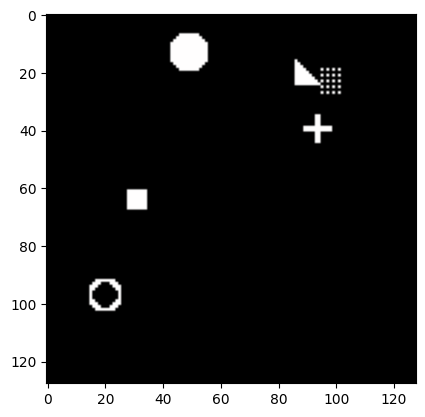

In [7]:
import torchvision.utils

def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.4, 0.5, 0.6])
  std = np.array([0.20, 0.21, 0.22])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

In [ ]:
#define unet
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)

        # Replaced Upsample with ConvTranspose2d
        #self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  
        self.up_trans3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.up_trans2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.up_trans1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)

    # --- ConvTranspose2d (new)---
    def forward(self, x):
        # Input assumed: 128x128x3

        conv1 = self.dconv_down1(x) # 128x128x3 -> 128x128x64
        x = self.maxpool(conv1) # 128x128x64 -> 64x64x64

        conv2 = self.dconv_down2(x) # 64x64x64 -> 64x64x128
        x = self.maxpool(conv2) # 64x64x128 -> 32x32x128

        conv3 = self.dconv_down3(x) # 32x32x128 -> 32x32x256
        x = self.maxpool(conv3) # 32x32x256 -> 16x16x256

        x = self.dconv_down4(x) # 16x16x256 -> 16x16x512

        x = self.up_trans3(x) # 16x16x512 -> 32x32x512

        x = torch.cat([x, conv3], dim=1) # 32x32x512 + 32x32x256 -> 32x32x768

        x = self.dconv_up3(x) # 32x32x768 -> 32x32x256

        x = self.up_trans2(x) # 32x32x256 -> 64x64x256

        x = torch.cat([x, conv2], dim=1) # 64x64x256 + 64x64x128 -> 64x64x384

        x = self.dconv_up2(x) # 64x64x384 -> 64x64x128

        x = self.up_trans1(x) # 64x64x128 -> 128x128x128

        x = torch.cat([x, conv1], dim=1) # 128x128x128 + 128x128x64 -> 128x128x192

        x = self.dconv_up1(x) # 128x128x192 -> 128x128x64

        out = self.conv_last(x) # 128x128x64 -> 128x128x6   (if n_class = 6)

        return out


    """ 
    # --- Upsample (old) ---
    def forward(self, x):
      #to be completed
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out"""

      
model = UNet(6).cuda() #6 classes

In [9]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [10]:
import time
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 15
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        epoch_samples = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = F.binary_cross_entropy_with_logits(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)

        print(f"{(loss.detach().cpu().numpy(), epoch_samples, phase)}")

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 0/14
----------
(array(0.02168726, dtype=float32), 2000, 'train')
(array(0.02058699, dtype=float32), 200, 'val')
0m 20s
Epoch 1/14
----------
(array(0.01120973, dtype=float32), 2000, 'train')
(array(0.0113766, dtype=float32), 200, 'val')
0m 20s
Epoch 2/14
----------
(array(0.01115468, dtype=float32), 2000, 'train')
(array(0.00865426, dtype=float32), 200, 'val')
0m 19s
Epoch 3/14
----------
(array(0.00691405, dtype=float32), 2000, 'train')
(array(0.0075889, dtype=float32), 200, 'val')
0m 17s
Epoch 4/14
----------
(array(0.00536505, dtype=float32), 2000, 'train')
(array(0.00659394, dtype=float32), 200, 'val')
0m 16s
Epoch 5/14
----------
(array(0.00545442, dtype=float32), 2000, 'train')
(array(0.00415501, dtype=float32), 200, 'val')
0m 16s
Epoch 6/14
----------
(array(0.00356566, dtype=float32), 2000, 'train')
(array(0.00316796, dtype=float32), 200, 'val')
0m 15s
Epoch 7/14
----------
(array(0.00314435, dtype=float32), 2000, 'train')
(array(0.00356364, dtype=float32), 200, 'val')
0

In [11]:
import math

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.cuda()
labels = labels.cuda()
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

inputs.shape torch.Size([3, 3, 128, 128])
labels.shape torch.Size([3, 6, 128, 128])
pred.shape (3, 6, 128, 128)


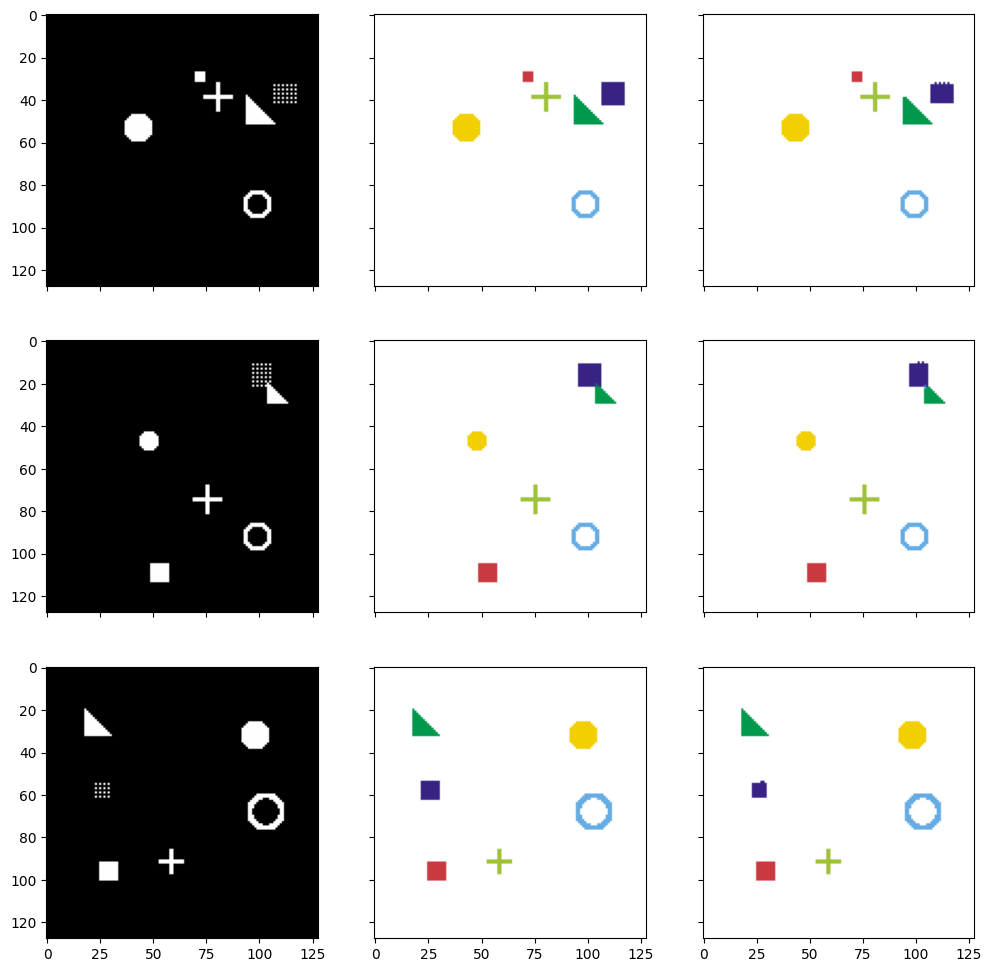

In [12]:
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])